In [1]:
%matplotlib inline
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.utils import to_categorical, plot_model
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D,  AveragePooling2D
from keras.layers import Input, Flatten, Dense
from keras.layers import Add, Concatenate
from sklearn.metrics import f1_score, confusion_matrix
import time

np.random.seed(776)

Using TensorFlow backend.


## Data

In [2]:
class Dataset(object) :
    
    def __init__(self, folders) :
        self.folders = folders
        self.input_shape = (50, 50, 3)
        self.num_classes = 2
        self.file_names = np.hstack([glob.glob(f + '/**/*.png', recursive=True) for f in folders])
        self.size = self.file_names.shape[0]

    def preprocess(self, images, labels) :
        def preprocess_x(images) :
            return images / 255.
        def preprocess_y(labels) :
            return to_categorical(labels, num_classes=2)
        return preprocess_x(images), preprocess_y(labels)
    
    def shuffle(self) :
        np.random.shuffle(self.file_names)
    
    def d_class(self, file_name) :
        return 0 if 'class0' in file_name else 1
    
    def next_batch(self, batch_size) :
        for i in range(0, self.size-batch_size+1, batch_size) :
            images, labels = [], []
            for file_name in self.file_names[i:i+batch_size] :
                image = cv2.imread(file_name)
                image = cv2.resize(image, (50,50))
                images.append(image)
                labels.append(self.d_class(file_name))
            images = np.array(images)
            labels = np.array(labels)
            yield self.preprocess(images, labels)
    
    def get_y(self) :
        return np.array([self.d_class(file_name) for file_name in self.file_names])

In [3]:
folder_data = glob.glob('IDC_regular_ps50_idx5/*')
np.random.shuffle(folder_data)
len_train = int(.6 * len(folder_data))
len_test = int(.2 * len(folder_data))
folder_train, folder_valid, folder_test = folder_data[:len_train], folder_data[len_train:-len_test], folder_data[-len_test:]
data_train = Dataset(folder_train)
data_valid = Dataset(folder_valid)
data_test = Dataset(folder_test)

Base Model

In [4]:
class base_model(object) :
    
    def __init__(self, input_shape, num_output, file_name='model.h5') :
        self.input_shape = input_shape
        self.num_output = num_output
        self.file_name = file_name
        
        self.model = self.create_model()
    
    def create_model(self) :
        pass
    
    def is_trained(self) :
        return os.path.isfile(self.file_name)
    
    def load(self) :
        self.model.load_weights(self.file_name)
    
    def train(self, data_train, data_valid, file_name='model.h5', batch_size=128, epochs=30) :
        f1_valid_best = 0
        for e in range(epochs) :
            data_train.shuffle()
            self.model.fit_generator(data_train.next_batch(batch_size), steps_per_epoch=data_train.size//batch_size)
            print('epoch {}'.format(e+1))
            f1_train, bac_train = self.evaluate(data_train)
            print('\ttrain: f1={} bac={}'.format(f1_train, bac_train))
            f1_valid, bac_valid = self.evaluate(data_valid)
            print('\tvalid: f1={} bac={}'.format(f1_valid, bac_valid))
            if f1_valid > f1_valid_best :
                print('Saving Model...')
                f1_valid_best = f1_valid
                self.model.save_weights(self.file_name)
    
    def balanced_accuracy_score(self, y_true, y_pred) :
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sensitivity, specificity = tp / (tp + fn), tn / (tn + fp)
        return (sensitivity + specificity) / 2.
    
    def evaluate(self, data, batch_size=128) :
        y_true = data.get_y()
        y_pred = np.argmax(self.model.predict_generator(data.next_batch(batch_size), steps=data.size//batch_size), axis=1)
        y_true = y_true[:y_pred.shape[0]]
        # F-1 Score
        f1 = f1_score(y_true, y_pred)
        # Balanced Accuracy Score
        bac = self.balanced_accuracy_score(y_true, y_pred)
        return f1, bac
    
    def print_model(self, to_file='model.png') :
        plot_model(self.model, to_file=to_file)

VGG Model

In [5]:
class VGG(base_model) :
        
    def create_model(self) :
        input = Input(shape=self.input_shape)
        
        conv11 = Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(input)
        conv12 = Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(conv11)
        pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv12)
        
        conv21 = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(pool1)
        conv22 = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(conv21)
        pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv22)
        
        conv31 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(pool2)
        conv32 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(conv31)
        pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv32)
        
        conv41 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(pool3)
        conv42 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu')(conv41)
        pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv42)
        
        conv51 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')(pool4)
        conv52 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu')(conv51)
        pool5 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv52)
        
        flatten = Flatten()(pool5)
        dense1 = Dense(256, activation='relu')(flatten)
        dense2 = Dense(256, activation='relu')(dense1)
        output = Dense(self.num_output, activation='softmax')(dense2)
        
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

ResNet Model

In [6]:
class ResNet(base_model) :
        
    def create_model(self) :
        input = Input(shape=self.input_shape)
        conv0 = Conv2D(16, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu')(input)
        pool0 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv0)
        
        block = pool0
        filters = 16
        for i in range(5) :
            strides = (1, 1) if i == 0 else (2, 2)
            block = self.residual_block(block, filters, strides)
            filters *= 2
        
        pool1 = AveragePooling2D(pool_size=block._keras_shape[1:3])(block)
        flatten = Flatten()(pool1)
        output = Dense(self.num_output, activation='softmax')(flatten)
        
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    
    def residual_block(self, block, filters, initial_strides=(2, 2)) :
        for i in range(3) :
            strides = initial_strides if i == 0 else (1, 1)
            base = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same', activation='relu')(block)
            for j in range(3) :
                strides = initial_strides if i == 0 and j == 0 else (1, 1)
                block = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same', activation='relu')(block)
            block = Add()([base, block])
        return block

Inception Model

In [7]:
class Inception(base_model) :
        
    def create_model(self) :
        input = Input(shape=self.input_shape)
        
        conv11 = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(input)
        conv12 = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(conv11)
        conv13 = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(conv12)
        pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv13)
        conv21 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(pool1)
        conv22 = Conv2D(64, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(conv21)
        conv23 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(conv22)
        
        block = conv23
        filters = 64
        for i in range(3) :
            block = self.inception_block(block, filters)
            filters *= 2
        
        pool2 = AveragePooling2D(pool_size=block._keras_shape[1:3])(block)
        flatten = Flatten()(pool2)
        output = Dense(self.num_output, activation='softmax')(flatten)
        
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    
    def inception_block(self, block, filters) :
        # 1
        tower1 = Conv2D(filters, kernel_size=(1, 1), strides=(2, 2), padding='same', activation='relu')(block)
        # 2
        tower2 = Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(block)
        tower2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(tower2)
        # 3
        tower3 = Conv2D(filters, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(block)
        tower3 = Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(tower3)
        # 4
        tower4 = Conv2D(filters, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(block)
        tower4 = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(tower4)
        tower4 = Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(tower4)
        block = Concatenate()([tower1, tower2, tower3, tower4])
        return block

## VGG Model

In [8]:
model_vgg = VGG(data_train.input_shape, data_train.num_classes, 'model_vgg.h5')

In [ ]:
start_time = time.time()
model_vgg.train(data_train, data_valid)
elapsed_time = time.time() - start_time

In [ ]:
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

In [9]:
model_vgg.load()

In [10]:
model_vgg.evaluate(data_test)

(0.7585221473770157, 0.8317138139594695)

In [11]:
y_true = data_test.get_y()
y_pred = np.argmax(model_vgg.model.predict_generator(data_test.next_batch(128), steps=data_test.size//128), axis=1)
y_true = y_true[:y_pred.shape[0]]
confusion_matrix(y_true, y_pred)

array([[32473,  4934],
       [ 3347, 13006]], dtype=int64)

In [12]:
model_vgg.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
__________

In [13]:
model_vgg.print_model(to_file='model_vgg.png')

## ResNet Model

In [14]:
model_resnet = ResNet(data_train.input_shape, data_train.num_classes, 'model_resnet.h5')

In [ ]:
start_time = time.time()
model_resnet.train(data_train, data_valid)
elapsed_time = time.time() - start_time

In [ ]:
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

In [15]:
model_resnet.load()

In [16]:
model_resnet.evaluate(data_test)

(0.7811076923076924, 0.8419260981690656)

In [17]:
y_true = data_test.get_y()
y_pred = np.argmax(model_resnet.model.predict_generator(data_test.next_batch(128), steps=data_test.size//128), axis=1)
y_true = y_true[:y_pred.shape[0]]
confusion_matrix(y_true, y_pred)

array([[33953,  3454],
       [ 3660, 12693]], dtype=int64)

In [18]:
model_resnet.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 25, 25, 16)   1216        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 13, 13, 16)   0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 13, 13, 16)   2320        max_pooling2d_6[0][0]            
__________________________________________________________________________________________________
conv2d_14 

In [19]:
model_resnet.print_model(to_file='model_resnet.png')

## Inception Model

In [20]:
model_inception = Inception(data_train.input_shape, data_train.num_classes, 'model_inception.h5')

In [ ]:
start_time = time.time()
model_inception.train(data_train, data_valid)
elapsed_time = time.time() - start_time

In [ ]:
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

In [21]:
model_inception.load()

In [22]:
model_inception.evaluate(data_test)

(0.7896298516409411, 0.851456208719216)

In [23]:
y_true = data_test.get_y()
y_pred = np.argmax(model_inception.model.predict_generator(data_test.next_batch(128), steps=data_test.size//128), axis=1)
y_true = y_true[:y_pred.shape[0]]
confusion_matrix(y_true, y_pred)

array([[33568,  3839],
       [ 3180, 13173]], dtype=int64)

In [24]:
model_inception.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 25, 25, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 25, 25, 32)   9248        conv2d_72[0][0]                  
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 25, 25, 32)   9248        conv2d_73[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [25]:
model_inception.print_model(to_file='model_inception.png')

Evaluation

In [26]:
def plot_result(file_names) :
    x_max, y_max = 0, 0
    for file_name in file_names :
        x, y = [int(f[1:]) for f in file_name[file_name.index('_x')+1:].split('_')[:2]]
        x_max, y_max = max(x_max, x), max(y_max, y)
    base_image = np.zeros((x_max+50, y_max+50, 3))
    base_image.fill(1.)

    for file_name in file_names :
        image = cv2.imread(file_name, 1)
        image = cv2.resize(image, (50,50))
        x, y = [int(f[1:]) for f in file_name[file_name.index('_x')+1:].split('_')[:2]]
        base_image[x:x+image.shape[0], y:y+image.shape[1], :] = image / 255.

    true_image = base_image.copy()
    vgg_image = base_image.copy()
    resnet_image = base_image.copy()
    inception_image = base_image.copy()
    for file_name in file_names :
        image = cv2.imread(file_name, 1)
        image = cv2.resize(image, (50,50))
        img = image.reshape((1, 50, 50, 3))/255.
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        heat = cv2.applyColorMap(gray, cv2.COLORMAP_JET) / 255.
        x, y = [int(f[1:]) for f in file_name[file_name.index('_x')+1:].split('_')[:2]]
        # True
        if 'class1' in file_name :
            true_image[x:x+image.shape[0], y:y+image.shape[1], :] = cv2.addWeighted(base_image[x:x+image.shape[0], y:y+image.shape[1], :], 0., heat, 1., 0)
        # VGG
        ratio = model_vgg.model.predict(img)[0]
        vgg_image[x:x+image.shape[0], y:y+image.shape[1], :] = cv2.addWeighted(base_image[x:x+image.shape[0], y:y+image.shape[1], :], ratio[0], heat, ratio[1], 0)
        # ResNet
        ratio = model_resnet.model.predict(img)[0]
        resnet_image[x:x+image.shape[0], y:y+image.shape[1], :] = cv2.addWeighted(base_image[x:x+image.shape[0], y:y+image.shape[1], :], ratio[0], heat, ratio[1],0 )
        # Inception
        ratio = model_inception.model.predict(img)[0]
        inception_image[x:x+image.shape[0], y:y+image.shape[1], :] = cv2.addWeighted(base_image[x:x+image.shape[0], y:y+image.shape[1], :], ratio[0], heat, ratio[1], 0)

    fig = plt.figure(figsize=(15, 15))
    plt.suptitle(file_names[0][:file_names[0].index('_x')][-10:])
    fig.add_subplot(221)
    plt.title('True Image')
    plt.imshow(true_image)
    fig.add_subplot(222)
    plt.title('VGG')
    plt.imshow(vgg_image)
    fig.add_subplot(223)
    plt.title('ResNet')
    plt.imshow(resnet_image)
    fig.add_subplot(224)
    plt.title('Inception')
    plt.imshow(inception_image)
    plt.show()

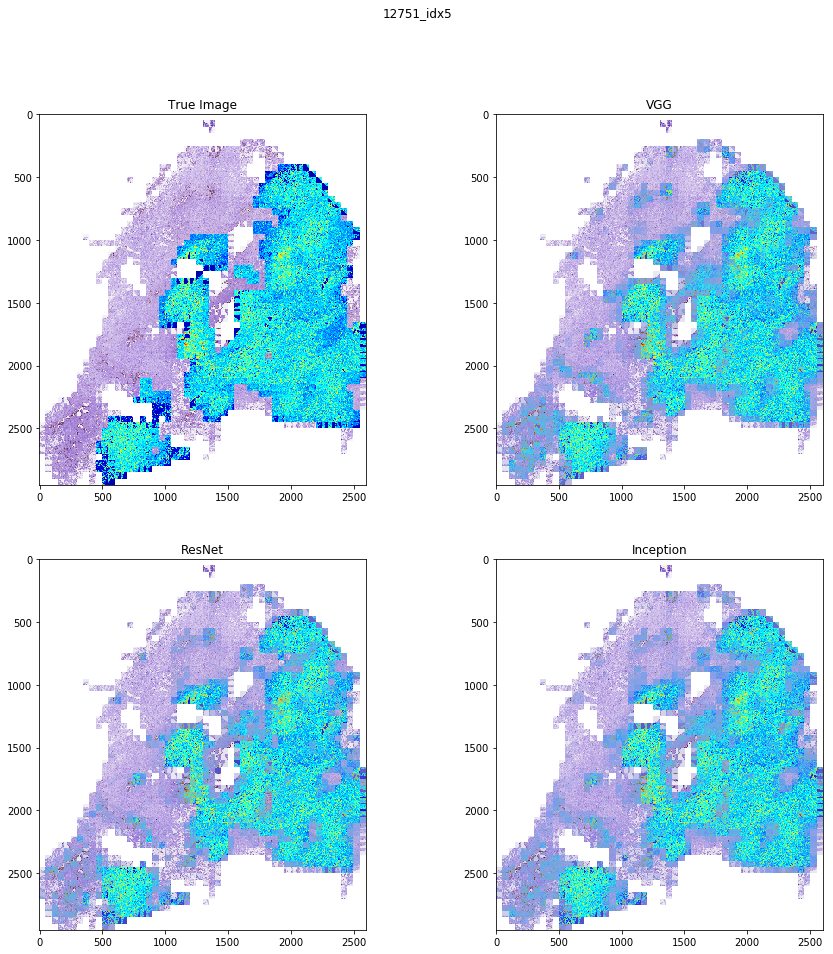

In [27]:
file_names = glob.glob(folder_test[2] + '/**/*.png', recursive=True)

plot_result(file_names)

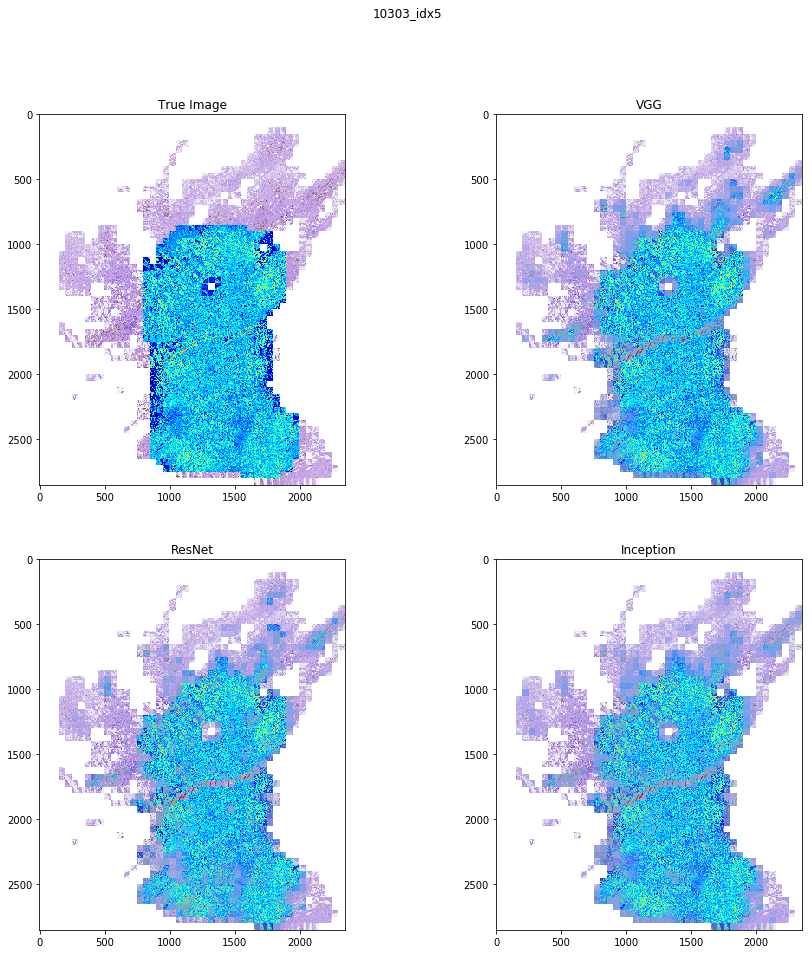

In [28]:
file_names = glob.glob(folder_test[25] + '/**/*.png', recursive=True)

plot_result(file_names)

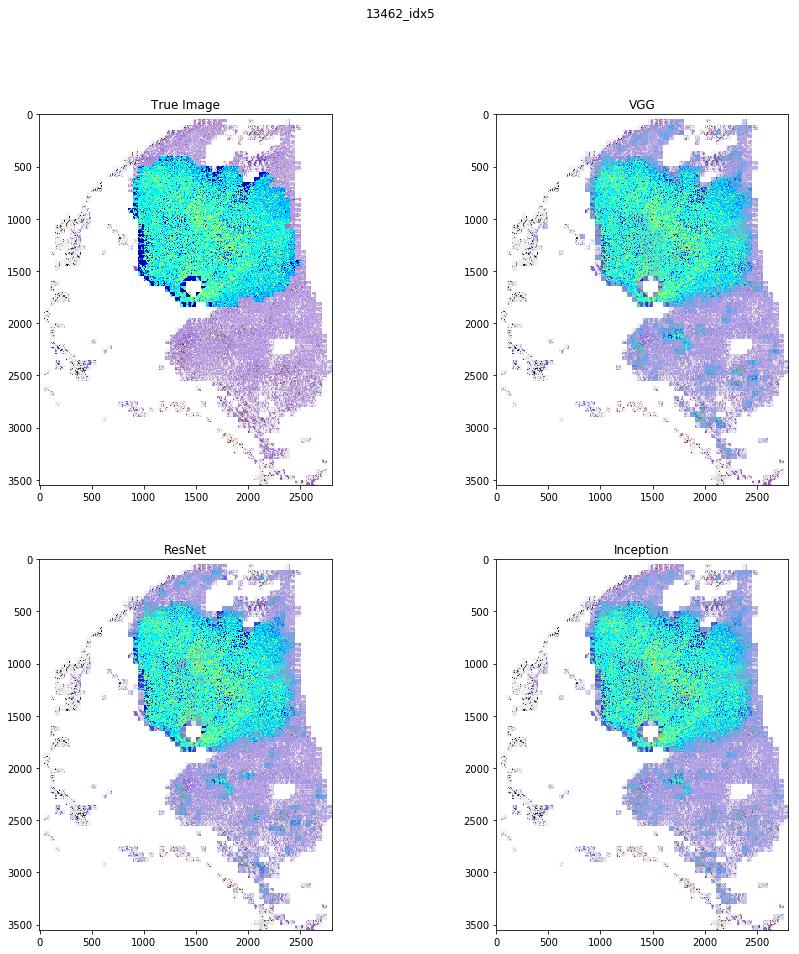

In [29]:
file_names = glob.glob(folder_test[50] + '/**/*.png', recursive=True)

plot_result(file_names)